# Superconductor Critical Temperature Prediction
The critical temperature of a superconductor is the temperature at which the material becomes superconducting (conducting an electric current with no resistance). This can be extremely beneficial to reduce resistive losses. The temperature tends to be very low, however, and we want to predict what the critical temperature may be on new materials. 

This dataset is particularly interesting, because it starts with 81 input features. Some of these are extracted from the chemical formula, but others require additional measurements of thermodynamic properties. The goal of this is to create a predictive model for the critical temperature of new superconductors using the fewest number of features. Using fewer features means that we will be able to make good preliminary predictions without the expense and time of unnecessary property measurements.

[Original publication](https://www.sciencedirect.com/science/article/pii/S0927025618304877?via=ihub)

[UCI repo with data](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data#)

[Towards Data Science Article](https://nrlewis929.medium.com/practical-machine-learning-techniques-to-accelerate-materials-science-research-9dc9f62f33e8)

In [40]:
# Import libraries
import chemparse
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from tqdm import tqdm
from xgboost import XGBRegressor

### Data Exploration
We first take a look at distributions and correlations between the inputs. Another interesting approach would be to look at clustering for high-dimensional data, such as t-SNE

In [41]:
# Load data
df = pd.read_csv('train.csv')
df['material'] = pd.read_csv('unique_m.csv')['material']
df.head()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...  gmean_Valence  wtd_gmean_Valence  entropy_Valence  \
0        51.968828  ...       2.213364           2.219783         1.368922   
1        47.094633  ...       1.888175           2.210679         1.557113   
2        51.968828  ...       2.213364           2.232679         1.368922   
3        51.968828  ...       2.213364           2.226222         1.368922   
4        51.968828  ...       2.213364           2.206963         1.368922   

   wtd_entropy_Valence  range_Valence  wtd_range_Valence  std_Valence  \
0             1.066221              1           1.085714     0.433013   
1             1.047221              2           1.128571     0.632456   
2             1.029175              1           1.114286     0.433013   
3             1.048834              1           1.100000     0.433013   
4             1.096052              1           1.057143     0.433013   

   wtd_std_Valence  critical_temp                material  
0         0.437059           29.0         Ba0.2La1.8Cu1O4  
1         0.468606           26.0  Ba0.1La1.9Ag0.1Cu0.9O4  
2         0.444697           19.0         Ba0.1La1.9Cu1O4  
3         0.440952           22.0       Ba0.15La1.85Cu1O4  
4         0.428809           23.0         Ba0.3La1.7Cu1O4  

[5 rows x 83 columns]

In [3]:
# Statistical distributions of the data
df.describe()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.041225              35.248990             0.966676   
50%            66.361592              39.918385             1.199541   
75%            78.116681              73.113234             1.444537   
max           208.980400             208.980400             1.983797   

       wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
count             21263.000000       21263.000000           21263.000000   
mean                  1.063884         115.601251              33.225218   
std                   0.401423          54.626887              26.967752   
min                   0.000000           0.000000               0.000000   
25%                   0.775363          78.512902              16.824174   
50%                   1.146783         122.906070              26.636008   
75%                   1.359418         154.119320              38.356908   
max                   1.958203         207.972460             205.589910   

       std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  \
count     21263.000000  ...      21263.000000   21263.000000   
mean         44.391893  ...          3.153127       3.056536   
std          20.035430  ...          1.191249       1.046257   
min           0.000000  ...          1.000000       1.000000   
25%          32.890369  ...          2.116732       2.279705   
50%          45.123500  ...          2.618182       2.615321   
75%          59.322812  ...          4.026201       3.727919   
max         101.019700  ...          7.000000       7.000000   

       wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  range_Valence  \
count       21263.000000     21263.000000         21263.000000   21263.000000   
mean            3.055885         1.295682             1.052841       2.041010   
std             1.174815         0.393155             0.380291       1.242345   
min             1.000000         0.000000             0.000000       0.000000   
25%             2.091251         1.060857             0.775678       1.000000   
50%             2.434057         1.368922             1.166532       2.000000   
75%             3.914868         1.589027             1.330801       3.000000   
max             7.000000         2.141963             1.949739       6.000000   

       wtd_range_Valence   std_Valence  wtd_std_Valence  critical_temp  
count       21263.000000  21263.000000     21263.000000   21263.000000  
mean            1.483007      0.839342         0.673987      34.421219  
std             0.978176      0.484676         0.455580      34.254362  
min             0.000000      0.000000         0.000000       0.000210  
25%             0.921454      0.451754         0.306892       5.365000  
50%             1.063077      0.800000         0.500000      20.000000  
75%             1.918400      1.200000         1.020436      63.000000  
max             6.992200      3.000000         3.000000     185.000000  

[8 rows x 82 columns]

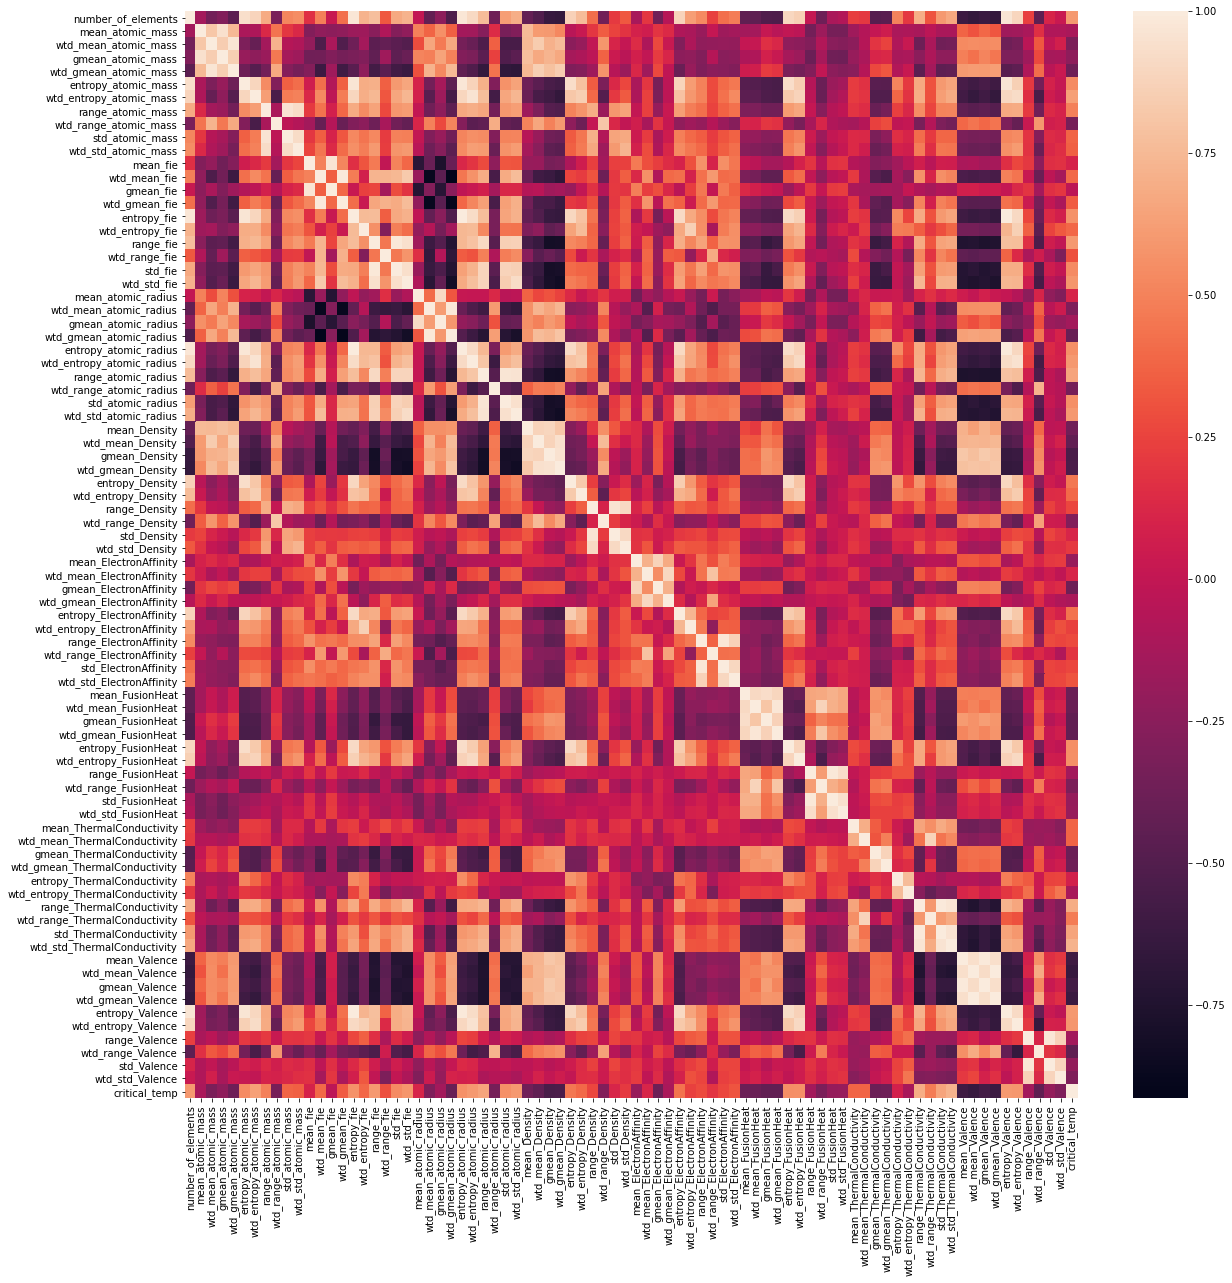

In [4]:
# Heatmap to show correlated variables
plt.figure(figsize=(20,20))
sns.heatmap(df.corr());

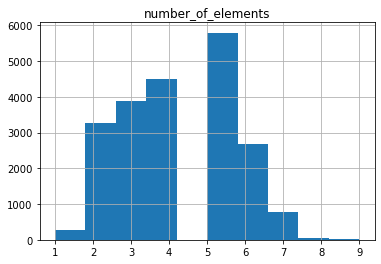

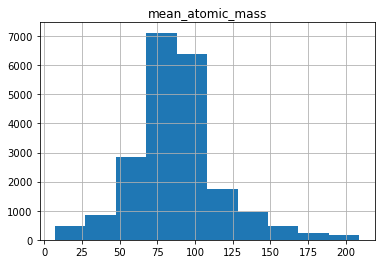

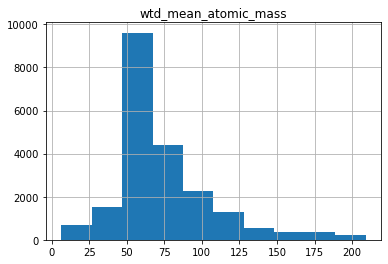

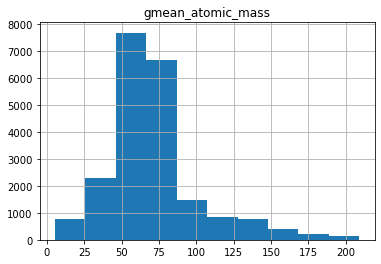

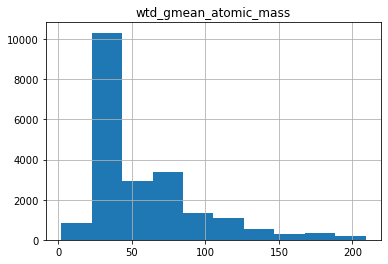

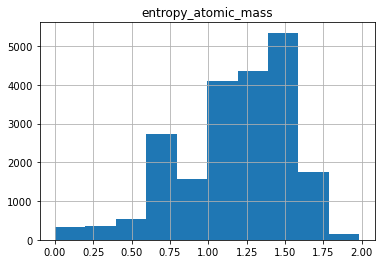

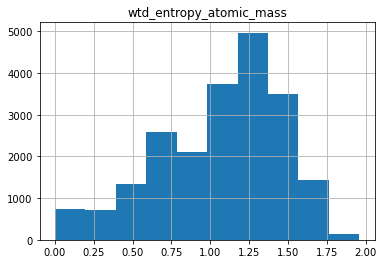

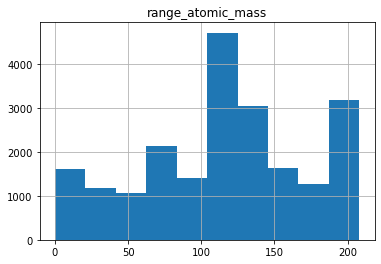

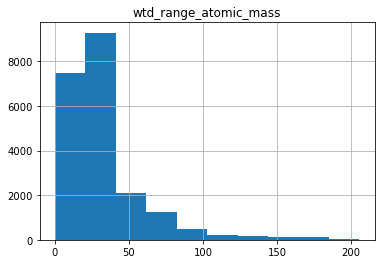

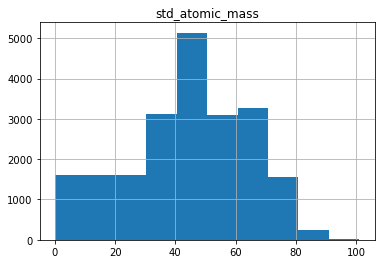

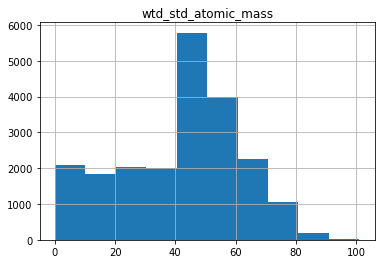

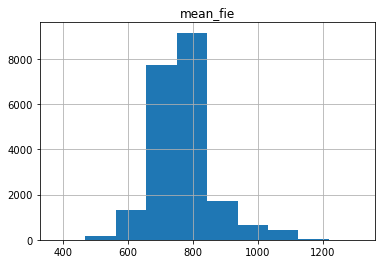

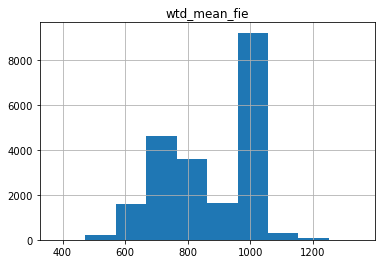

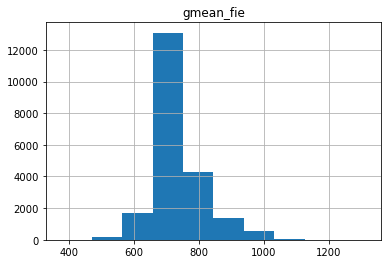

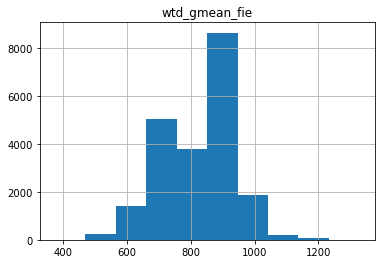

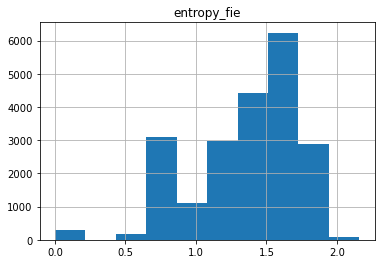

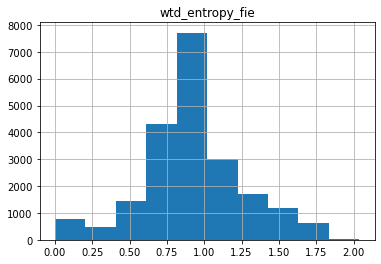

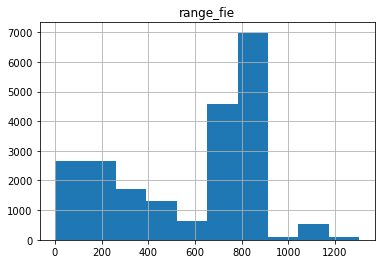

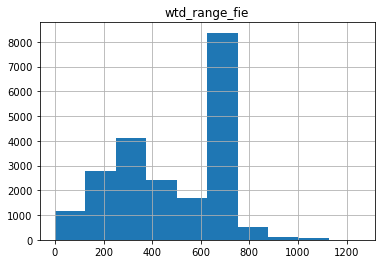

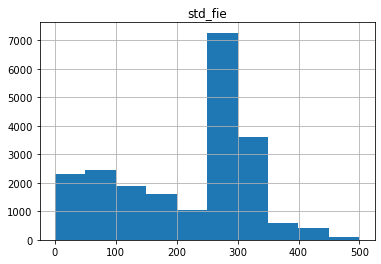

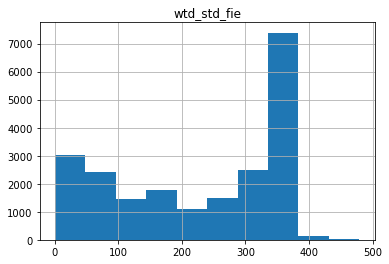

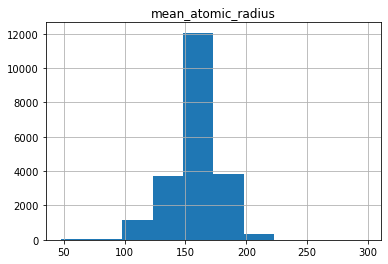

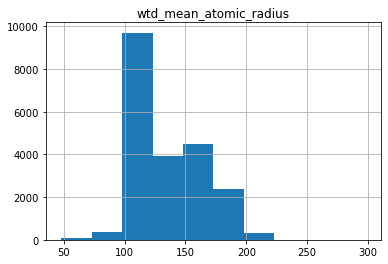

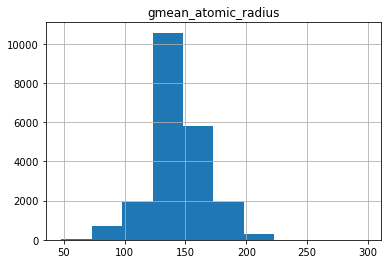

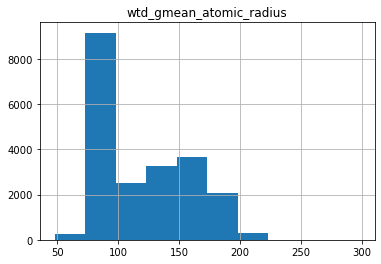

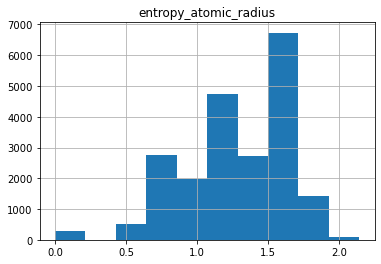

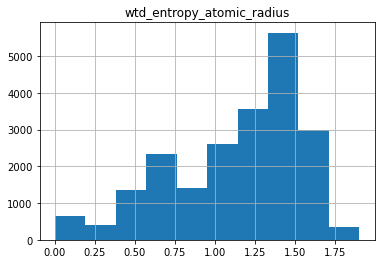

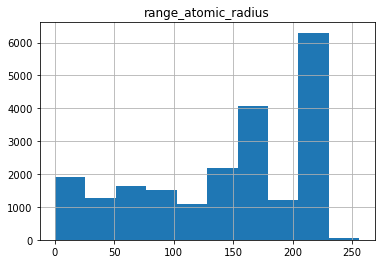

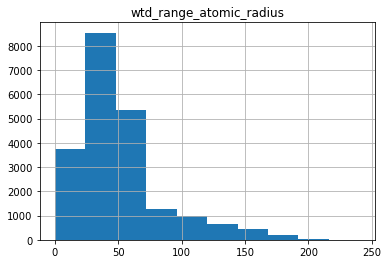

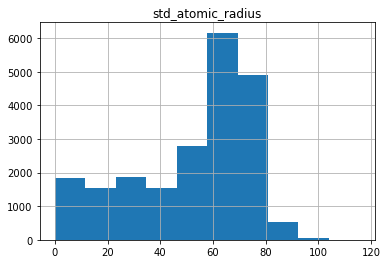

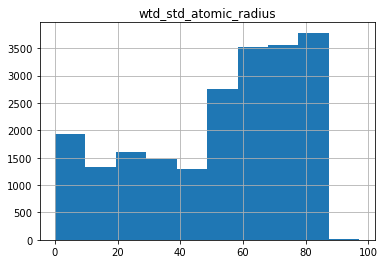

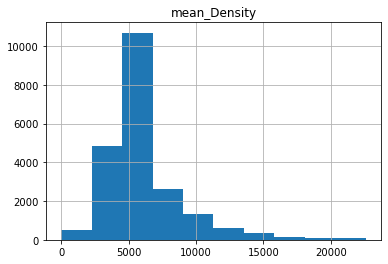

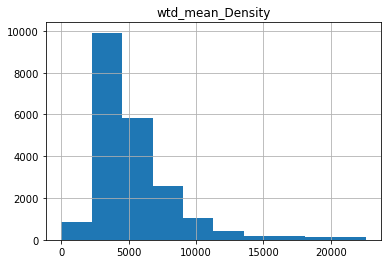

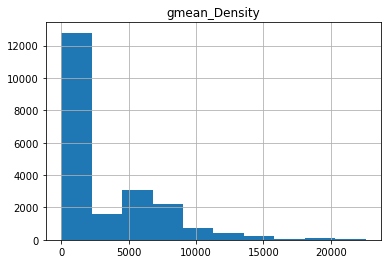

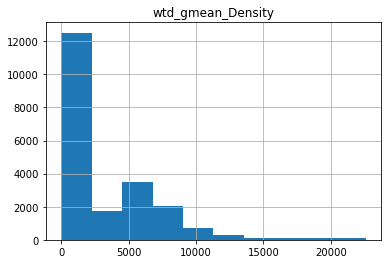

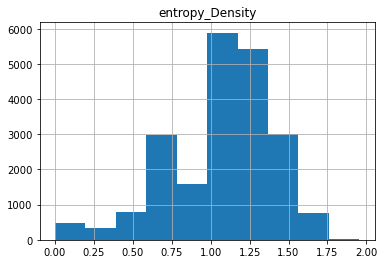

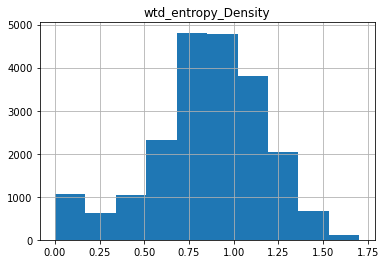

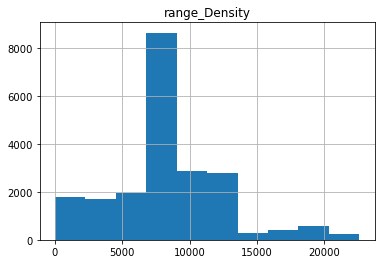

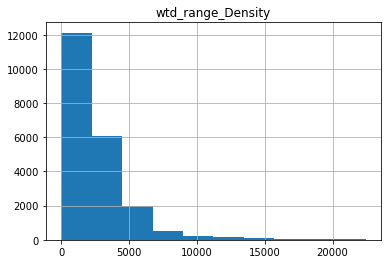

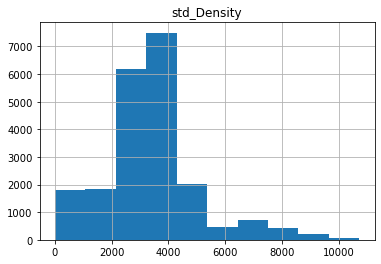

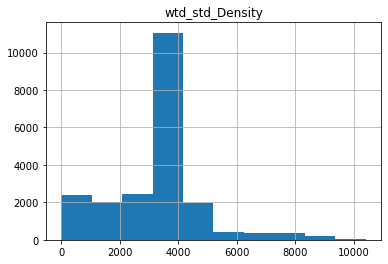

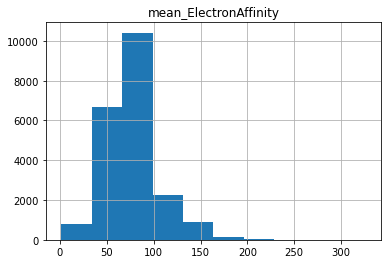

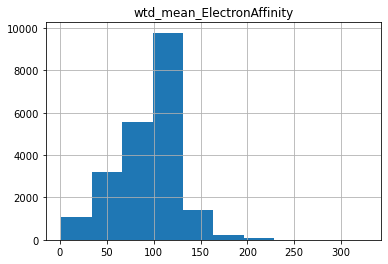

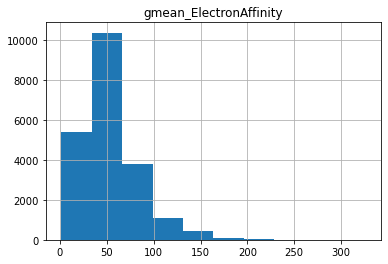

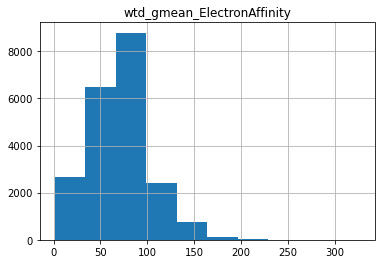

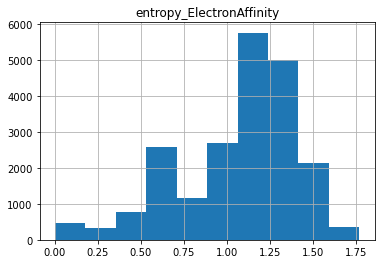

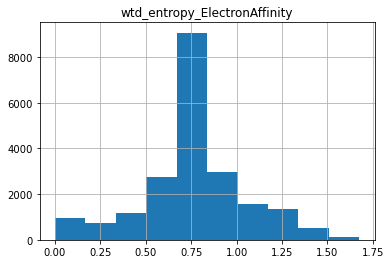

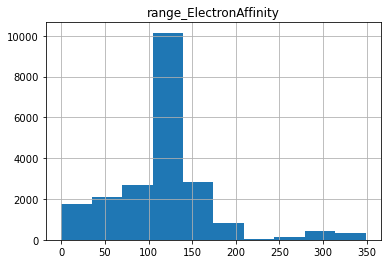

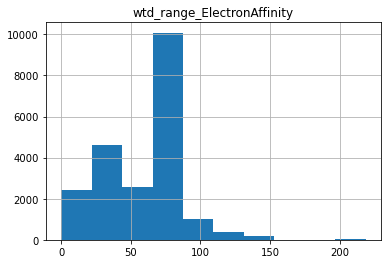

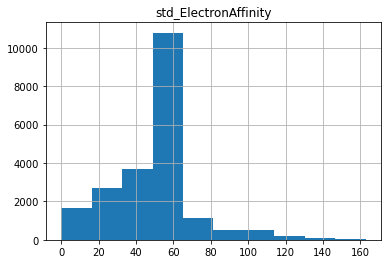

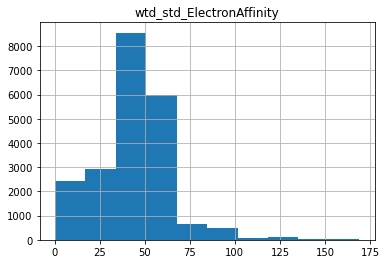

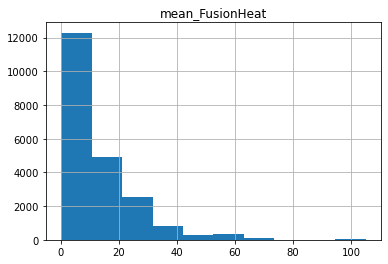

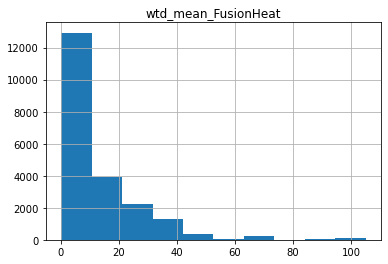

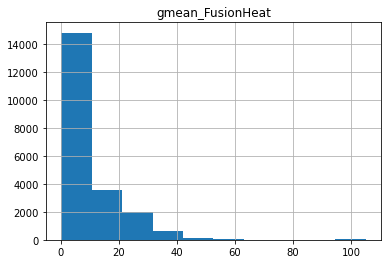

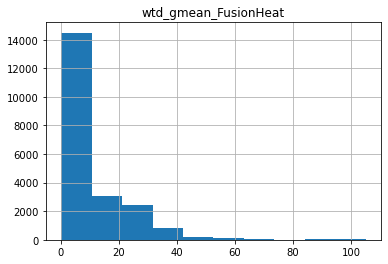

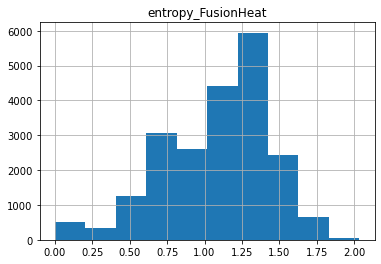

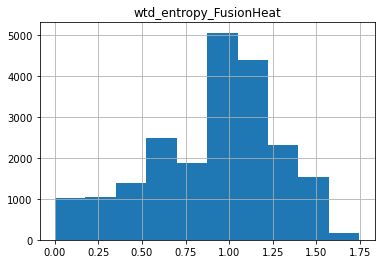

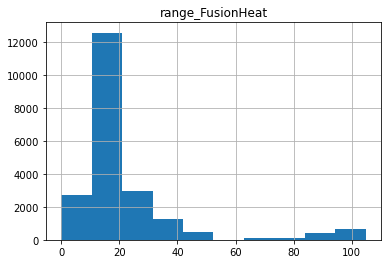

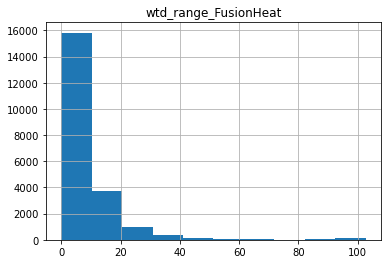

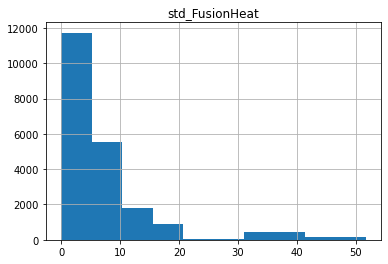

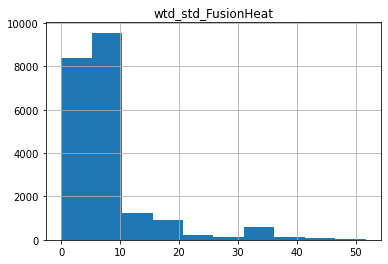

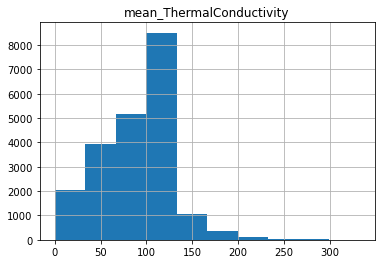

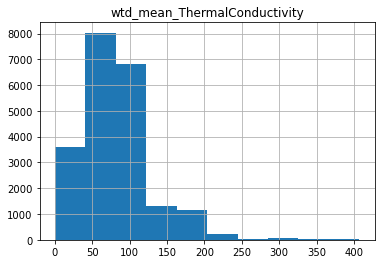

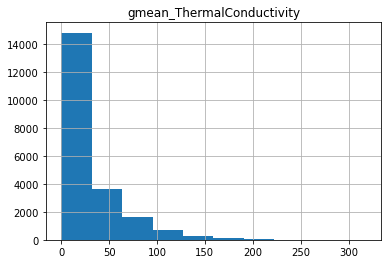

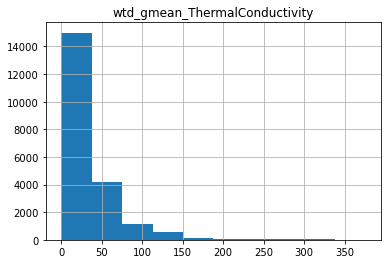

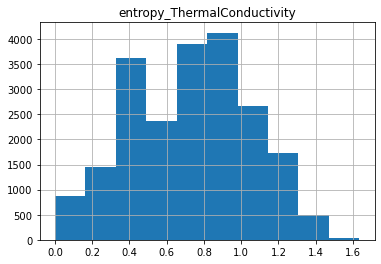

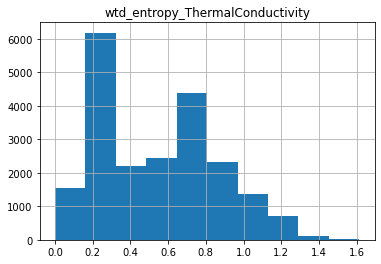

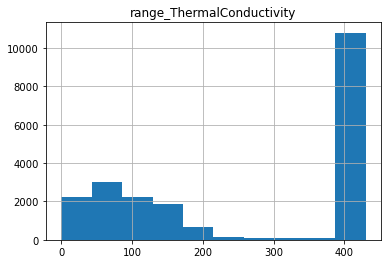

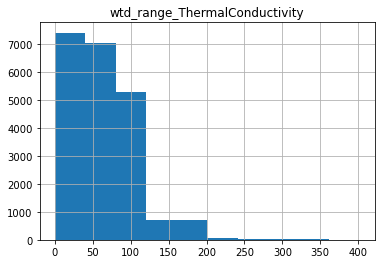

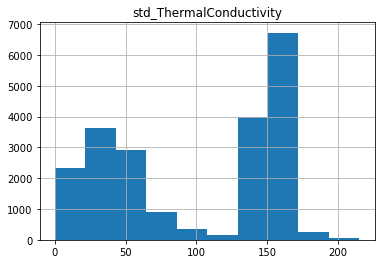

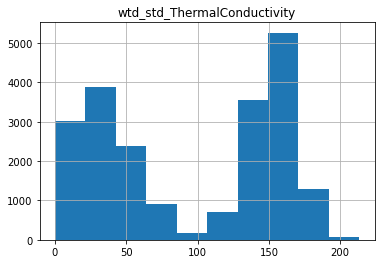

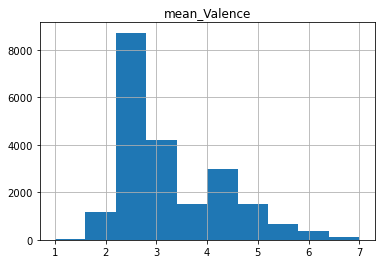

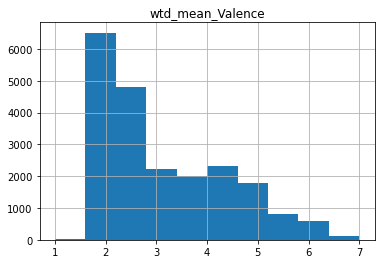

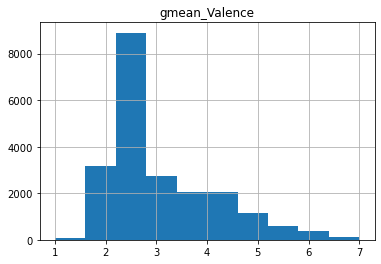

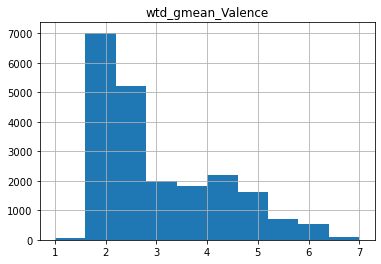

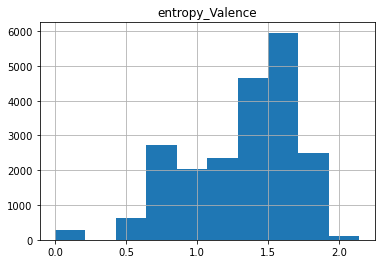

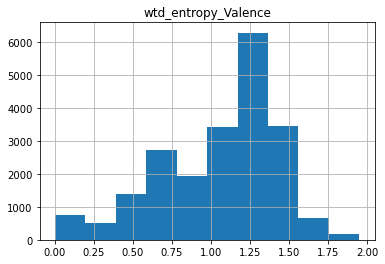

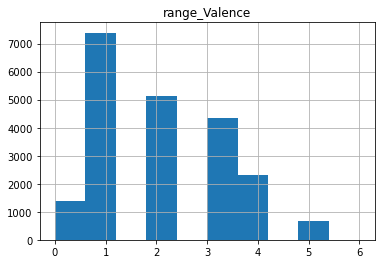

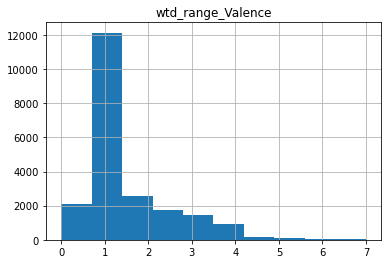

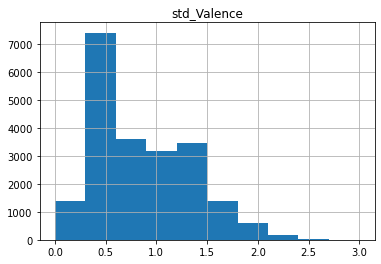

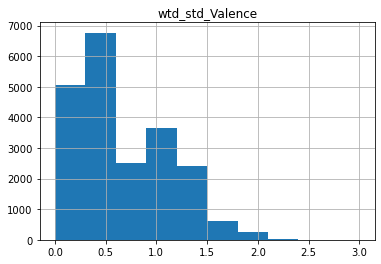

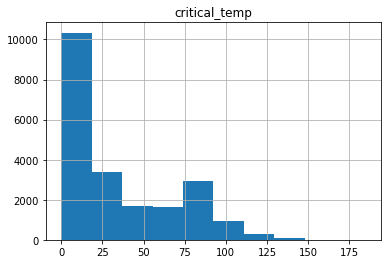

In [5]:
# Plot distributions
for column in df.columns[:-1]:
    df[column].hist()
    plt.title(column)
    plt.show()


t-SNE is a method for clustering high-dimensional data. This is a preliminary exploration to see if there is a clustering trend based on the critical temperature

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21263 samples in 0.003s...
[t-SNE] Computed neighbors for 21263 samples in 9.933s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21263
[t-SNE] Computed conditional probabilities for sample 2000 / 21263
[t-SNE] Computed conditional probabilities for sample 3000 / 21263
[t-SNE] Computed conditional probabilities for sample 4000 / 21263
[t-SNE] Computed conditional probabilities for sample 5000 / 21263
[t-SNE] Computed conditional probabilities for sample 6000 / 21263
[t-SNE] Computed conditional probabilities for sample 7000 / 21263
[t-SNE] Computed conditional probabilities for sample 8000 / 21263
[t-SNE] Computed conditional probabilities for sample 9000 / 21263
[t-SNE] Computed conditional probabilities for sample 10000 / 21263
[t-SNE] Computed conditional probabilities for sample 11000 / 21263
[t-SNE] Computed conditional probabilities for sample 12000 / 21263
[t-SNE] Computed conditional probabilities for sam

Text(0.5, 1.0, 't-SNE clustering by critical temperature bins')

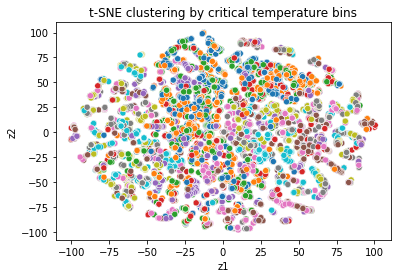

In [74]:
# t-SNE
tsne = TSNE(n_components=2, verbose=1)
z = tsne.fit_transform(df[df.columns[:-1]]) 

# Load results in dataframe, along with binned critical temperature
tsne_df = pd.DataFrame(columns=['critical_temp','z1','z2'])
tsne_df['critical_temp'] = pd.qcut(df['critical_temp'], q=10) # Critical temperature into bins based on quantiles
tsne_df['z1'] = z[:,0]
tsne_df['z2'] = z[:,1]

# Plot results
sns.scatterplot(x='z1', y='z2',data=tsne_df, hue=tsne_df['critical_temp'])
plt.legend([],[], frameon=False)
plt.title('t-SNE clustering by critical temperature bins')

### Model preparation
We will extract some additional features, select a target, perform a train/test split, and scale the data in preparation for a regression model.

Note that we log scale the target (critical temperature). This is because some regression models predicted negative values for the critical temperature, which is physically impossible. Predicting the log scale forces the values to always be positive once the transform is inverted. 

In [6]:
# Use chemparse package to create the new features of atom counts
chem_df = df['material'].apply(chemparse.parse_formula)

# Convert the dictionary into a dataframe and fill NaN with 0
chem_df = pd.json_normalize(chem_df)
chem_df = chem_df.fillna(0)

# Merge atom counts into main df
df = df.join(chem_df)

# 5289 is notoriously poor in linear regression, consider dropping
# df.drop(5289,inplace=True)

In [7]:
# Define target and potential features
target = 'critical_temp'
features = list(df.columns)
features.remove(target)
features.remove('material')

# Input and output values
X = df[features]
y = np.log10(df[target]) # log scale forces values to always be positive and non-zero

# Train/test split
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Scale
s = MinMaxScaler()
s.fit(X_train_unscaled)
X_train = s.transform(X_train_unscaled)
X_test = s.transform(X_test_unscaled)

Text(0.5, 1.0, 'Log Scale Critical Temperature Distribution')

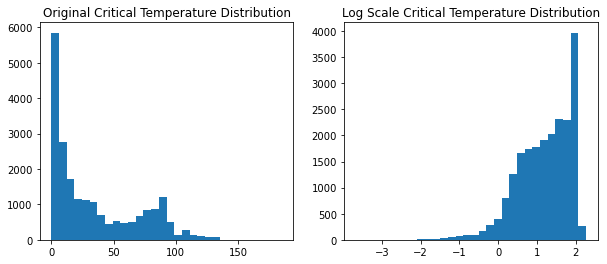

In [8]:
# Distributions of raw critical temperature and log scale critical temperature
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(df[target],bins=30)
plt.title('Original Critical Temperature Distribution')
plt.subplot(122)
plt.hist(y,bins=30)
plt.title('Log Scale Critical Temperature Distribution')


### Regression models
The following blocks of code explore several basic linear regression models, including Ridge and Lasso regression for insights into feature selection

In [9]:
# dataframe to store predictions
predictions = pd.DataFrame()
predictions['actual'] = 10**y_test

0.5793678275870883


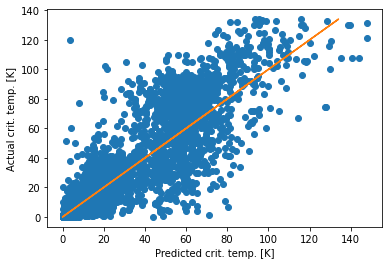

In [10]:
# Initiate and fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test data
y_pred = lr.predict(X_test)

# Display metrics
print(mean_squared_error(y_pred,y_test,squared=False))
plt.scatter(10**y_pred,10**y_test)
plt.plot(10**y_test,10**y_test,color='tab:orange')
plt.xlabel('Predicted crit. temp. [K]')
plt.ylabel('Actual crit. temp. [K]')
predictions['linear'] = 10**y_pred

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.55it/s]


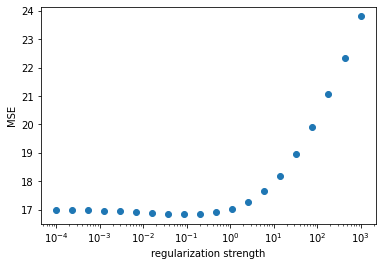

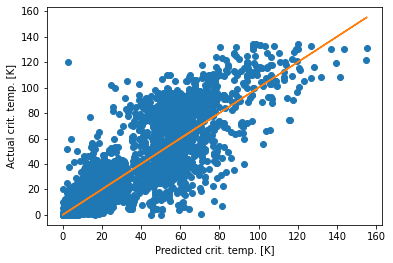

In [11]:
# Ridge regression with varying regularization strength

# Range of alphas (regularization strength)
alphas = np.logspace(-4,3,20)
# dataframe to store coefficients
ridge_coefs = pd.DataFrame(index=alphas,columns=features)
# list to store mse
ridge_mse = []

for alpha in tqdm(alphas):
    # Initiate and fit model with given alpha
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Save coefficients
    ridge_coefs.loc[alpha] = ridge.coef_

    # Predict on test data
    y_pred = ridge.predict(X_test)
    
    # Save mse
    ridge_mse.append(mean_squared_error(10**y_pred,10**y_test,squared=False))

# Plot MSE and alphas
plt.scatter(alphas,ridge_mse)
plt.xscale('log')
plt.xlabel('regularization strength')
plt.ylabel('MSE')
plt.show()

# Plot coefficients and alphas
pd.options.plotting.backend = 'plotly'
fig = ridge_coefs.plot(log_x=True)
fig.show()
pd.options.plotting.backend = 'matplotlib'

# Find optimal alpha, fit model, plot and save predictions
optimal_ridge_alpha = alphas[np.argmin(ridge_mse)]
ridge = Ridge(alpha=optimal_ridge_alpha)
ridge.fit(X_train, y_train)
# Predict on test data
y_pred = ridge.predict(X_test)
plt.scatter(10**y_pred,10**y_test)
plt.plot(10**y_pred,10**y_pred,color='tab:orange')
plt.xlabel('Predicted crit. temp. [K]')
plt.ylabel('Actual crit. temp. [K]')
plt.show()
predictions['ridge'] = 10**y_pred

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


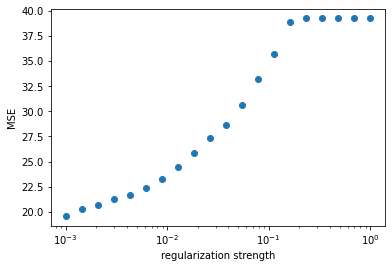

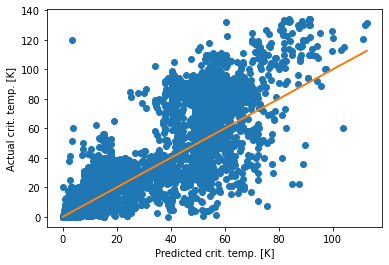

In [12]:
# Ridge regression with varying regularization strength

# Range of alphas (regularization strength)
alphas = np.logspace(-3,0,20)
# dataframe to store coefficients
lasso_coefs = pd.DataFrame(index=alphas,columns=features)
# list to store mse
lasso_mse = []

for alpha in tqdm(alphas):
    # Initiate and fit Lasso model with given alpha
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    # Save coefficients
    lasso_coefs.loc[alpha] = lasso.coef_

    # Predict on test data
    y_pred = lasso.predict(X_test)
    
    # Save mse
    lasso_mse.append(mean_squared_error(10**y_pred,10**y_test,squared=False))
    
# Plot mse and alphas
plt.scatter(alphas,lasso_mse)
plt.xscale('log')
plt.xlabel('regularization strength')
plt.ylabel('MSE')
plt.show()

# Plot coefficients and alphas
pd.options.plotting.backend = 'plotly'
fig = lasso_coefs.plot(log_x=True)
fig.show()
pd.options.plotting.backend = 'matplotlib'

# Find optimal lasso alpha, fit model, plot and save predictions
optimal_lasso_alpha = alphas[np.argmin(lasso_mse)]
lasso = Lasso(alpha=optimal_lasso_alpha)
lasso.fit(X_train, y_train)
# Predict on test data
y_pred = lasso.predict(X_test)
plt.scatter(10**y_pred,10**y_test)
plt.plot(10**y_pred,10**y_pred,color='tab:orange')
plt.xlabel('Predicted crit. temp. [K]')
plt.ylabel('Actual crit. temp. [K]')
plt.show()
predictions['lasso'] = 10**y_pred

Text(0, 0.5, 'Actual crit. temp. [K]')

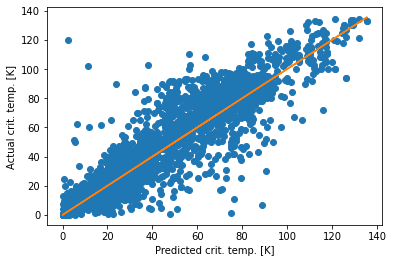

In [13]:
# XGBoost Regressor

# Initialize and fit model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Make and store predictions
y_pred = xgb.predict(X_test)
predictions['xgb_raw'] = 10**y_pred

# Plot
plt.scatter(10**y_pred,10**y_test)
plt.plot(10**y_pred,10**y_pred,color='tab:orange')
plt.xlabel('Predicted crit. temp. [K]')
plt.ylabel('Actual crit. temp. [K]')

In [14]:
# Print model performance up to this point
for model_name in predictions.columns[1:]:
    mse = mean_squared_error(predictions['actual'],predictions[model_name],squared=False)
    print(f'{model_name} mse: {mse}')

linear mse: 16.984735685312433
ridge mse: 16.84388703812713
lasso mse: 19.572236732438693
xgb_raw mse: 10.81624306753451


### Feature selection

The Lasso and Ridge models gave a good first indication of the importance of features, based on the weights at various regularization strengths. However, the models still performed poorly. XGBRegressor was far superior to any other regression algorithm. There are many options to look at feature importance, but the one we'll use is recursive feature elimination (RFE). This trains the specified model (for this case, XGBRegressor) on all input features and shows the resulting prediction performance, then removes the least important feature iteratively and retrains the model on the subset of features. Ideally we'd do RFE with cross validation, but this method is already computationally expensive, so for now we'll just use regular RFE

In [15]:
# This takes around 45 minutes to complete; set to False to skip this and use the previous results
compute_all = False

if compute_all:
    # Define step size and search space
    step = 5
    max_features = X_train.shape[1]
    min_features = 5
    search_space = range(min_features,max_features,step)
    # List to store MSE
    rmse = []
    
    for n_features in tqdm(search_space):
        # RFE to select n_features
        selector = RFE(estimator = XGBRegressor(), n_features_to_select = n_features, step = step)
        selector.fit(X_train, y_train)
        # Predict on feature subset and store prediction
        y_pred = selector.predict(X_test)
        rmse.append(mean_squared_error(10**y_pred,10**y_test,squared=False))

    # Plot results
    plt.scatter(search_space, rmse)
    plt.xlabel('Features')
    plt.ylabel('RMSE')
    plt.savefig('feature_selection.png',dpi=300)
    

Based on running the above code, we see the following: 
<img src="feature_selection.png" width="500">

With only 5 features, we get very poor performance. However, if we have about 20 features, we get the same amount of performance as if we had all 150! This is great news, because it means that we can signficantly cut down on the amount of data that we need to make a prediction on the critical temperature. This can lead to faster and cheaper exploration. 

In [16]:
# Find the 20 most important features and fit the model
n_features = 20
selector = RFE(estimator = XGBRegressor(), n_features_to_select = n_features, step = 5)
selector.fit(X_train, y_train)

# Predict and save predictions on the subset of data
y_pred = selector.predict(X_test)
predictions['xgb_subset'] = 10**y_pred

Now to see which features are actually used. The following code shows the ranking (1 is the most important subset of features, 2 is the next most important, etc.). Interestingly, of the 20 most important features, the majority of them are simply the element counts! These are apparently the most important elements to include in superconductor materials. Other elements may be important, but they would contribute to the `wtd_mean_atomic_mass` feature. 

In [17]:
# Display the rankings
rankings = selector.ranking_
for rank in range(1,max(rankings)):
    print(rank)
    features_index = [i for i, x in enumerate(rankings) if x == rank]
    features_list = [features[i] for i in features_index]
    print(features_list)

1
['gmean_Density', 'wtd_gmean_ElectronAffinity', 'wtd_gmean_ThermalConductivity', 'range_ThermalConductivity', 'wtd_range_ThermalConductivity', 'wtd_mean_Valence', 'wtd_gmean_Valence', 'entropy_Valence', 'wtd_std_Valence', 'Ba', 'Cu', 'Ca', 'Ti', 'Fe', 'Zn', 'Pr', 'Nb', 'Ce', 'Mg', 'Pd']
2
['mean_Density', 'Gd', 'Ni']
3
['range_ElectronAffinity', 'Bi', 'Sn', 'Si', 'Tc']
4
['wtd_mean_atomic_mass', 'wtd_std_fie', 'wtd_std_ElectronAffinity', 'wtd_range_FusionHeat', 'wtd_std_FusionHeat']
5
['std_Density', 'gmean_ElectronAffinity', 'std_FusionHeat', 'wtd_std_ThermalConductivity', 'Sr']
6
['range_fie', 'wtd_gmean_atomic_radius', 'wtd_std_atomic_radius', 'std_ElectronAffinity', 'wtd_mean_ThermalConductivity']
7
['wtd_mean_fie', 'wtd_gmean_fie', 'range_Density', 'entropy_ThermalConductivity', 'Pb']
8
['wtd_mean_Density', 'wtd_mean_FusionHeat', 'range_FusionHeat', 'wtd_range_Valence', 'Rh']
9
['entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'gmean_ThermalConductivity', 'wtd_entropy_ThermalCond

### Hyperparameter Optimization
The XGBoost model can potentially perform better, if we search over a range of hyperparameters. We will now use Bayesian optimization to select the hyperparameters for the best performing model. 

Note: we could potentially include a feature selection in tandem with hyperparameter optimization, but this would greatly increase the computational expense.

In [18]:
# Only use the subsets of 20 most important features
X_train_sub = selector.transform(X_train)
X_test_sub = selector.transform(X_test)

In [19]:
from hyperopt.pyll.base import scope #quniform returns float, some parameters require int; use this to force int

# Define search space for the hyperparameters of interest
space = {'eta' : hp.uniform('eta',0.01,0.3),
         'gamma' : scope.int(hp.quniform('gamma',0,100,1)),
         'max_depth' : scope.int(hp.quniform('max_depth',2,15,1)),
         'subsample' : hp.uniform('subsample',0.5,1.0),
         'lambda' : hp.loguniform('lambda', -3, 3),
         'colsample_bytree' : hp.uniform('colsample_bytree',0.5,1.0)
        }

In [20]:
def xgboost(params):
    # Initialize model with hyperparameters
    xgb = XGBRegressor(eta = params['eta'],
                       gamma = params['gamma'],
                       max_depth = params['max_depth'],
                       subsample = params['subsample'],
                       reg_lambda = params['lambda'],
                       colsample_bytree = params['colsample_bytree']
                      )
    
    # Split into validation set
    X_train_hyper, X_val, y_train_hyper, y_val = train_test_split(X_train_sub, y_train, test_size=0.2, shuffle=True)
    
    # Fit
    xgb.fit(X_train_hyper, y_train_hyper)
    
    # Predict on validation set
    y_pred = xgb.predict(X_val)
    
    # calculate validation loss
    validation_loss = mean_squared_error(10**y_pred, 10**y_val, squared=False)
    
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': xgb, 'params': params}

In [21]:
# Initiate trials and start hyperparameter search space for 100 iterations
trials = Trials()
best = fmin(xgboost, space, algo=tpe.suggest, max_evals=250, trials=trials)

# Find the best model and set of hyperparameters
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

# Find the worst model and set of hyperparameters
worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

100%|███████████████████████████████████████████████| 250/250 [09:03<00:00,  2.17s/trial, best loss: 10.27439875491341]


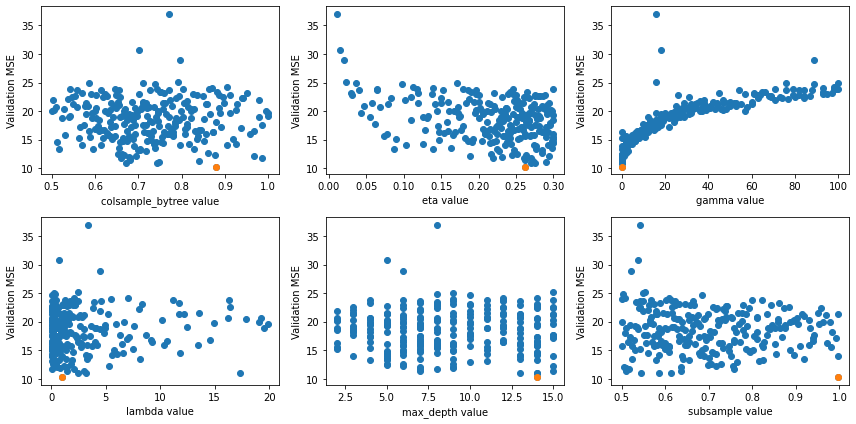

In [22]:
# Plot search space 

# Retrieve lists of losses and corresponding hyperparameters
trials_losses = [x['loss'] for x in trials.results]
trials_params = [x['params'] for x in trials.results]

params_list = list(trials_params[0].keys())

# Initiate plot and iterate over the hyperparameter list
fig, ax = plt.subplots(2,3,figsize=(12,6))
for i,param in enumerate(params_list):
    # Specify row and column for subplots
    row = i//3
    col = i%3
    param_list = [x[param] for x in trials_params]
    # Plot values
    ax[row][col].scatter(param_list,trials_losses)
    ax[row][col].scatter(best_params[param],np.min(trials_losses))
    if param == 'learning_rate':
        ax[row][col].set_xscale('log')
    ax[row][col].set_xlabel(param+' value')
    ax[row][col].set_ylabel('Validation MSE')
plt.tight_layout()

Interestingly, the only completely clear trend is that gamma values should be low! 

For an in-depth description of the hyperparameters, see [this link](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook).

Text(0, 0.5, 'Actual crit. temp. [K]')

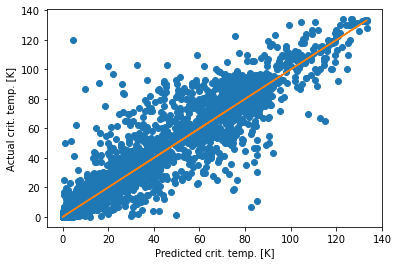

In [72]:
# Predictions based on model with optimal hyperparameters
y_pred = best_model.predict(X_test_sub)
predictions['xgb_best'] = 10**y_pred

# Plot
plt.scatter(10**y_pred,10**y_test)
plt.plot(10**y_pred,10**y_pred,color='tab:orange')
plt.xlabel('Predicted crit. temp. [K]')
plt.ylabel('Actual crit. temp. [K]')

Text(0, 0.5, 'Actual crit. temp. [K]')

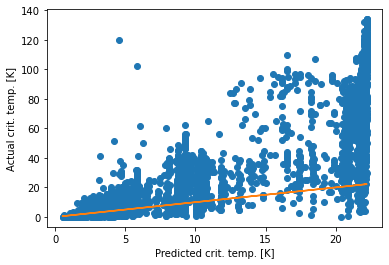

In [73]:
# Predictions based on model with worst set of hyperparameters (primarily to show the importance of hyperparameters!)
y_pred = worst_model.predict(X_test_sub)
predictions['xgb_worst'] = 10**y_pred

# Plot
plt.scatter(10**y_pred,10**y_test)
plt.plot(10**y_pred,10**y_pred,color='tab:orange')
plt.xlabel('Predicted crit. temp. [K]')
plt.ylabel('Actual crit. temp. [K]')

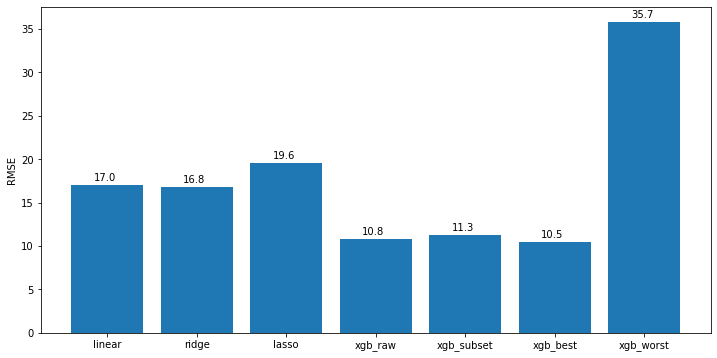

In [71]:
# Plot RMSE for each model
models = list(predictions.columns[1:])
rmse = []
plt.figure(figsize=(12,6))
for model in models:
    rmse.append(mean_squared_error(predictions['actual'],predictions[model],squared=False))
plt.bar(x = models, height = rmse)
plt.ylabel('RMSE')
for index, value in enumerate(rmse):
    plt.text(index-.15, value+0.5,
             str(round(value,1)))

[Confidence Intervals](https://towardsdatascience.com/generating-confidence-intervals-for-regression-models-2dd60026fbce#:~:text=Calculate%20the%20residuals%20of%20the,limits%20of%20the%20confidence%20interval): how certain are we in our predictions? There are several ways to look at this, the simplest is to look at the distribution of the residuals from our test dataset predctions (not train dataset). Other ways include a jackknife leave-one-out method, but this is a good first approximation.

12.445766448974615


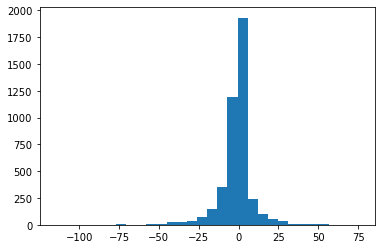

In [39]:
# Calculate residuals
residuals = predictions['xgb_best'] - predictions['actual']
# Find confidence interval using 95% confidence
confidence = residuals.quantile(0.95)
print(confidence)
# Plot residuals to make sure normal distribution
plt.hist(residuals,bins = 30);

### Identify high-performing materials
Now we want to find high-performing materials without testing every single possibility. The scenario I'm constructing is that we have about 200 potential materials, and we want to quickly find materials that have a high critical temperature, above a certain threshold (say we're only interested in materials with critical temperature > 100K). We can either randomly start trying materials, or create some kind of selection function to find samples that have the greatest likelihood of high performance.

I started looking at some clustering algorithms, but none of them did what I wanted to do efficiently. So I came up with a 'pseudo k-means' selection criteria. k-means is a clustering algorithm that finds similar samples based on their features and a similarity metric. Unfortunately, most k-means implementations use Euclidean distance, which suffers from the curse of dimensionality. Even though we got our input features down from 158 to 20, it is still fairly high-dimensional. While cosine similarity also suffers in high dimensionality (especially with sparse data), it tends to work better. So the approach was to select the highest performing materials based on cosine similarity to other known high-performing materials. According to the workflow in [this paper](https://arxiv.org/pdf/1704.07423.pdf), we then evaluate the sample, then if it meets the criteria, we are finished; otherwise, we add the sample to the dataset and retrain the model. We can then evaluate how long it takes to find a sample with the desired critical temperature.


In [27]:
def find_candidate(threshold = 100.0, update_model = False):
    """
    A function that takes a threshold critical temperature, and determines how many samples must be tried before finding a 
    material with a predicted critical temperature that is greater than the threshold. 
    
    Inputs:
        - threshold: the temperature (in K) above which we want to find candidates with a predicted critical temperature
        - update_model: whether or not to update the regression model with the latest values for unsuccessful candidates
        
    Returns:
        - cosine_count: how many samples were tested before a qualifying material was found, using cosine similarity to 
                        high-performing known samples
        - random_count: how many samples were tested before a qualifying material was found, using random sampling
    """
    # Take a random subsample from the test dataset
    X_, X_unknown_sl, y_, y_unknown_sl = train_test_split(X_test_sub, y_test, test_size=0.1, shuffle=True)

    # Use the known training subset values to find the indices of the highest performing materials
    top_performing_quantile = y_train.quantile(0.998)
    top_list_index = [i for i,v in enumerate(y_train) if v > top_performing_quantile]

    # Find averate cosine similarity of our unknown material inputs to the high-performing known material inputs
    ave_similarity = [] # List to track average similarity
    for input_features in X_unknown_sl:
        similarity = [] # List to track sample-to-sample similarity
        for i in top_list_index:
            # Compute and store cosine similarity of our unknown input features to the high-performing known materials
            cos_sim = cosine_similarity(input_features.reshape(1, -1),X_train_sub[i].reshape(1, -1))
            similarity.append(cos_sim[0][0])
        # Compute average similarity
        ave_similarity.append(sum(similarity)/len(similarity))

    # Sort our unknown samples based on average cosine similarity
    X_unknown_index = range(len(X_unknown_sl))
    _, sorted_samples = (list(t) for t in zip(*sorted(zip(ave_similarity, X_unknown_index))))
    sorted_samples = sorted_samples[::-1] # Previous line returns ascending, reverse for descending
    
    ###########################################################################################################
    ##### Finding candidates with predicted critical temperature above threshold, using cosine similarity #####
    ###########################################################################################################
    # Initialize count, current iteration of model, and current iteration of X and y for training the model
    cosine_count = 0
    model = best_model
    X_train_updated = X_train_sub
    y_train_updated = y_train
    # Iterate through our sorted samples
    for sample in sorted_samples:
        # Select input sample features
        new_sample = X_test_sub[sample].reshape(1, -1)
        # Predict
        predicted_temp = model.predict(new_sample)[0]
        # If sample is greater than threshold, exit loop
        if 10**predicted_temp >= threshold:
            break
        # Otherwise, increment our counter and update the model with the sample
        else:
            cosine_count += 1
            # Update model only if specified; this step is far more important when we don't already have thousands of datapoints
            if update_model:
                # Load optimal hyperparameters
                model = XGBRegressor(**best_params) 
                # Append our new sample data to the training data and retrain the model
                X_train_updated = np.vstack((X_train_updated,new_sample))
                y_train_updated = np.append(y_train_updated,y_unknown_sl.iloc[sample])
                model.fit(X_train_updated,y_train_updated)

    #########################################################################################################
    ##### Finding candidates with predicted critical temperature above threshold, using random sampling #####
    #########################################################################################################
    # Create a list of samples
    random_list = list(range(len(y_unknown_sl)))
    # Initialize count, current iteration of model, and current iteration of X and y for training the model
    random_count = 0
    model = best_model
    X_train_updated = X_train_sub
    y_train_updated = y_train
    # Iterate through our possible samples
    for i in range(len(y_unknown_sl)):
        # Randomly select sample from list
        random_selection = random.choice(random_list)
        # Select input sample features
        new_sample = X_test_sub[random_selection].reshape(1, -1)
        # Predict
        predicted_temp = model.predict(new_sample)[0]
        # If sample is greater than threshold, exit loop
        if 10**predicted_temp >= threshold:
            break
        # Otherwise, increment our counter and update the model with the sample
        else:
            random_count += 1
            random_list.remove(random_selection) # Remove sample from list of potential samples
            # Update model only if specified; this step is far more important when we don't already have thousands of datapoints
            if update_model: 
                # Load optimal hyperparameters
                model = XGBRegressor(**best_params)
                # Append our new sample data to the training data and retrain the model
                X_train_updated = np.vstack((X_train_updated,new_sample))
                y_train_updated = np.append(y_train_updated,y_unknown_sl.iloc[sample])
                model.fit(X_train_updated,y_train_updated)

    # Return counts of attempted samples before finding candidate with critical temperature above threshold
    return cosine_count, random_count

Now we have a selection function, time to see how it performs compared to random sampling. Try this exercise 50 times on different subsets so that we have statistical data. Ideally, we'd hope that our selection criteria would help us find high-performing materials in fewer tries. We do see this is the case in general, given the higher peak at lower values below. There is, however, clear room for improvement. 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:26<00:00,  2.93s/it]


<AxesSubplot:>

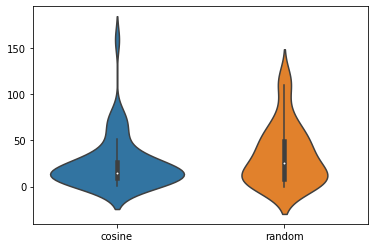

In [28]:

n_samples = 50
counts_df = pd.DataFrame(index = range(n_samples), columns = ['cosine','random'])
for i in tqdm(range(n_samples)):
    cos, rand = find_candidate(threshold = 100.0, update_model = False)
    counts_df['cosine'].iloc[i] = cos
    counts_df['random'].iloc[i] = rand
    
sns.violinplot(data=counts_df)